In [1]:
# Install uproot to be able open ROOT files
#pip install uproot

"""
Combine *_hist.root files, but keep signal and background separate.

Features
--------
* Auto‑detects files whose base name starts with "signal_" or "background_".
* Loads all top‑level TH* objects with uproot.
* Sums histograms *within* each category (bin‑by‑bin addition, errors propagated).
* Writes two output ROOT files:
      combined_signal_hist.root
      combined_background_hist.root
* Easy to extend to extra categories – just add a new entry to CATEGORY_MAP.
"""


# ----------------------------------------------------------------------
# 1️⃣  Define how filenames map to a logical category
# ----------------------------------------------------------------------
CATEGORY_MAP = {
    "signal_": "signal",
    "background_": "background",
    # Add more prefixes here if you ever need extra groups, e.g.:
    # "data_": "data",
    # "mc_":   "mc",
}


def infer_category(filename: str) -> str | None:
    """
    Return the category name for a given filename based on its prefix.
    If no prefix matches, return None (the file will be ignored).
    """
    for prefix, cat in CATEGORY_MAP.items():
        if filename.startswith(prefix):
            return cat
    return None


# ----------------------------------------------------------------------
# 2️⃣  Locate all *_hist.root files (adjust the glob pattern if needed)
# ----------------------------------------------------------------------
def find_root_files(root_dir: pathlib.Path) -> list[pathlib.Path]:
    """Return a sorted list of all ROOT files ending with '_hist.root'."""
    pattern = "*_hist.root"
    files = sorted(root_dir.glob(pattern))
    if not files:
        sys.exit(f"No files matching '{pattern}' were found in {root_dir}")
    return files


# ----------------------------------------------------------------------
# 4️⃣  Combine histograms *per category*
# ----------------------------------------------------------------------
def combine_per_category(
    per_file_hists: list):
    """
    Input: list of (category, {name → histogram}) tuples.
    Output: {category → {hist_name → summed_histogram}}.
    """
    combined_by_cat = defaultdict(dict)  # category → (name → summed histogram)

    sig_list = []
    bg_list = []

    for cat, hist_df in per_file_hists:
        # Defensive normalisation – works even if cat is a numpy/pandas scalar
        cat_norm = str(cat).strip().lower()

        if cat == "signal":
            sig_list.append(hist_df)
            
        elif cat == "background":
            bg_list.append(hist_df)

        else:
            # Optional: warn about unexpected categories
            print(f"⚠️  Unexpected category '{cat}' – ignored.")

    # Concatenate each list (empty list → empty DataFrame)
    sig_df = pd.concat(sig_list, axis=0) if sig_list else pd.DataFrame()
    bg_df  = pd.concat(bg_list,  axis=0) if bg_list  else pd.DataFrame()

    # If you still want counts you can compute them here
    sig_count = len(sig_list)
    bg_count  = len(bg_list)
    print(f"Collected {sig_count} signal frames and {bg_count} background frames.")

    return sig_df, bg_df


# ----------------------------------------------------------------------
# 🎬  Main driver
# ----------------------------------------------------------------------


def main():
    # Directory that holds your *_hist.root files – change if needed
    root_dir = pathlib.Path(target_path)

    # 1️⃣ Find files
    files = find_root_files(root_dir)
    print(f"🔎 Discovered {len(files)} *_hist.root file(s):")
    for p in files:
        print(f"   • {p.name}")

    # 2️⃣ Load histograms and tag each with its inferred category
    per_file_hists = []  # List of (category, {name → hist}) tuples
    for p in files:
        cat = infer_category(p.name)
        if cat is None:
            print(f"⚠️  Skipping {p.name}: unknown prefix (not signal_/background_)")
            continue

        hists = load_histograms(p)
        if hists.empty:
            print(f"⚠️  No histograms found in {p.name}")
        else:
            print(f"📂 Loaded {len(hists)} histogram(s) from {p.name} → category '{cat}'")
        per_file_hists.append((cat, hists))

    if not per_file_hists:
        sys.exit("❌ No files matched known categories – nothing to combine.")


    # 3️⃣ Combine within each category
    sig_df, bg_df = combine_per_category(per_file_hists)
    for cat, hist_dict in sig_df.items():
        print(f"🧮 Category '{cat}' produced {len(hist_dict)} combined histogram(s).")

    return sig_df, bg_df

# For some reason the histograms aren't combining
#nsig_df, nbg_df = main()

# Plots for the Invisible Higgs Decay Simulation Analysis

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib 
from pathlib import Path
import sys
from collections import defaultdict
import os
from typing import List, Iterable, Union, Literal

## A test to see the histograms proprieties

In [3]:
# 1️⃣ Get the directory that contains this script
current_dir = pathlib.Path.cwd()         # e.g. …/project

# 2️⃣ Move up to the parent folder (if you’re already there, this is optional)
parent_dir = current_dir.parent             # e.g. …/ (same as project in this case)
# 3️⃣ Navigate to the sibling folder and file you need
#    Replace 'data' and 'dataset.csv' with your actual folder/file names
target_path = parent_dir / "output_files" / "signal"
sig_target_path = parent_dir / "output_files" / "signal" /"signal_20251027_155520_hist.root"
# 4️⃣ If you just need the string representation:
sig_target_path_str = str(sig_target_path)

print("Signal Full path:", sig_target_path)

Signal Full path: /home/mazeeqe/Documents/mestrado/code/tomaz-example/output_files/signal/signal_20251027_155520_hist.root


In [4]:
def load_branch(tree,branch):
    '''
    Loads a ROOT branch into a Numpy array
    '''
    return tree[branch].array(library="np")

def load_histograms(file_path: pathlib.Path):

    file = uproot.open(file_path)

    # Import Events
    tree = file["events"]
    
    #df_list = []
    data_dict = {}
    
    for branch in tree.keys():
        # Each Branch is stored as an Numpy array
        branch_data = load_branch(tree, branch)

        data_dict[branch] = branch_data

        
    # Turn into a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    df = df.transpose()   # now each original array becomes a row


    return df

def load_and_combine_histograms(file_paths, verbose=True):
    """
    Load multiple files using load_histograms and combine them
    into a single pandas DataFrame, with error handling.

    Parameters
    ----------
    file_paths : list of str
        List of file paths to be loaded.
    verbose : bool
        If True, prints warnings when a file fails to load.

    Returns
    -------
    pd.DataFrame
        Combined DataFrame containing all successfully loaded files.
    """
    dfs = []

    for path in file_paths:
        try:
            df = load_histograms(path)

            # Get the folder name containing the file
            folder_name = os.path.basename(os.path.dirname(path))
            df["source_file"] = folder_name

            dfs.append(df)

        except Exception as e:
            if verbose:
                print(f"[WARNING] Failed to load '{path}': {e}")

    if not dfs:
        raise RuntimeError("No files were successfully loaded.")

    return pd.concat(dfs, axis=0, ignore_index=True)


def collect_files(
    root_dir: str | os.PathLike,
    file_type: Literal["root", "slcio"] = "root",
    sample_type: Literal["signal", "background", "both"] = "background",
    max_files: int = 10,
) -> List[str]:
    """
    Recursively collect files of a given type under ``root_dir``.

    Parameters
    ----------
    root_dir : str or Path-like
        The top-level directory to start the search from.
    file_type : {"root", "slcio"}
        File type to search for.
    sample_type : {"signal", "background", "both"}
        Select which samples to collect.
    max_files : int
        Maximum number of files to collect.

    Returns
    -------
    List[str]
        A list of file paths as strings.
    """
    base_path = Path(root_dir).expanduser().resolve()

    if not base_path.is_dir():
        raise NotADirectoryError(f"The supplied path is not a directory: {base_path}")

    pattern = f"*.{file_type}"
    files: List[str] = []

    for p in base_path.rglob(pattern):
        if not p.is_file():
            continue

        is_signal = any("signal" in part.lower() for part in p.parts)

        if sample_type == "signal" and not is_signal:
            continue
        if sample_type == "background" and is_signal:
            continue
        # sample_type == "both" → keep everything

        files.append(str(p))
        if len(files) >= max_files:
            break

    return files

In [5]:
input_dir = "../output_files/"
background_files = collect_files(input_dir, file_type="root", sample_type="background", max_files=10000)

nbg_df = load_and_combine_histograms(background_files, verbose=True)
print(len(nbg_df))
nbg_df.head()

224581


,invMass,recoilMass,totalEnergy,muonEnergy_high,muonEnergy_low,px,py,pz,met,missingEnergy,missingPx,missingPy,missingPz,weight,source_file
0,90.116798,127.550583,108.703773,75.571877,33.131897,9.000523,6.493093,-59.768749,11.098184,141.296234,-9.000523,-6.493093,59.768749,0.1,higgs
1,89.971237,124.479607,110.199295,46.596756,63.602543,46.488998,15.338804,40.651653,48.954121,138.952881,-47.222763,-14.985824,-40.415417,0.1,higgs
2,89.487747,127.573318,108.466217,63.210621,45.255592,-34.152557,42.369186,28.201370,54.420082,137.004868,33.206173,-43.825897,-27.976820,0.1,higgs
3,119.147354,128.145737,120.549530,67.595879,52.953648,0.694436,-18.137836,-2.575470,18.151125,129.450470,-0.694436,18.137836,2.575470,0.1,higgs
4,91.884903,130.447617,107.852509,77.418793,30.433714,9.750203,-32.214622,-45.348415,33.657810,142.147491,-9.750203,32.214622,45.348415,0.1,higgs


In [6]:
signal_files = collect_files(input_dir, file_type="root", sample_type="signal", max_files=10000)
nsig_df = load_and_combine_histograms(signal_files, verbose=True)
print(nsig_df.keys())
print(len(nsig_df))
nsig_df.head()

Index(['invMass', 'recoilMass', 'totalEnergy', 'muonEnergy_high',
       'muonEnergy_low', 'px', 'py', 'pz', 'met', 'missingEnergy', 'missingPx',
       'missingPy', 'missingPz', 'weight', 'source_file'],
      dtype='object')
28159


,invMass,recoilMass,totalEnergy,muonEnergy_high,muonEnergy_low,px,py,pz,met,missingEnergy,missingPx,missingPy,missingPz,weight,source_file
0,71.224838,151.866882,89.018852,69.881767,19.137085,11.450953,-11.392396,50.896633,16.152740,32.861115,-38.579548,16.280138,16.550903,0.1,signal
1,23.850317,158.366302,75.977905,72.553673,3.424232,-27.751377,66.550140,2.178025,72.104515,53.717316,-42.317875,-9.867889,-29.722055,0.1,signal
2,25.498913,142.323151,85.788628,83.049889,2.738738,-19.162386,30.835329,-73.426697,36.304470,38.212524,-34.467552,-22.405886,-5.485229,0.1,signal
3,35.572300,172.790344,67.817772,62.481354,5.336416,-22.043854,53.311394,2.413500,57.689133,68.197586,47.524952,16.847164,-39.099468,0.1,signal
4,20.893509,212.888916,35.229691,31.375854,3.853836,3.810331,-27.980904,-2.672596,28.239149,116.418869,-24.815527,-43.156864,24.667295,0.1,signal


### Constants

In [7]:
# Particle Masses
z_mass = 91.1880
h_mass = 125.20

In [8]:
print(len(nsig_df))
nsig_df.head()

def check_duplicates(df):
    """
    Check if there are duplicated rows in the DataFrame
    """
    # 1️⃣ Boolean check – is there any duplicate row?
    has_duplicates = df.duplicated().any()
    print("Has Duplicated Rows:",has_duplicates)          # False → no repeated rows
    
    # 2️⃣ Count of duplicate rows
    num_duplicates = df.duplicated().sum()
    percentage_duplicate = num_duplicates/len(df)*100
    print(f"Found a total of {num_duplicates}/{len(df)} ({percentage_duplicate:.2f}%) duplicated row(s).")          # 0 → no repeats
    
    # 3️⃣ Direct assertion – raise an error if a duplicate exists
    no_duplicated_df = df.drop_duplicates()
    
    # 4️⃣ Compare shapes after dropping duplicates
    print("Dropping duplicates.")
    print(f"New DataFrame has lenth: {len(no_duplicated_df)} row(s).")

    return no_duplicated_df

new_nsig_df = check_duplicates(nsig_df)

28159
Has Duplicated Rows: True
Found a total of 22720/28159 (80.68%) duplicated row(s).
Dropping duplicates.
New DataFrame has lenth: 5439 row(s).


In [9]:
print(len(nbg_df))
nbg_df.head()

new_nbg_df = check_duplicates(nbg_df)

224581
Has Duplicated Rows: True
Found a total of 94400/224581 (42.03%) duplicated row(s).
Dropping duplicates.
New DataFrame has lenth: 130181 row(s).


In [10]:
nsig_df.columns

Index(['invMass', 'recoilMass', 'totalEnergy', 'muonEnergy_high',
       'muonEnergy_low', 'px', 'py', 'pz', 'met', 'missingEnergy', 'missingPx',
       'missingPy', 'missingPz', 'weight', 'source_file'],
      dtype='object')

In [11]:
# Functions to import the ROOT branches into Numpy arrays
def load_branch(tree,branch):
    '''
    Loads a ROOT branch into a Numpy array
    '''
    return tree[branch].array(library="np")

def filter_between(arr, low, high):
    """
    Filter the array between two values
    """
    filtered = arr[(arr >= low) & (arr <= high)]

    return filtered
    
# MC weights
#weights = load_branch(sig_tree,"weight")

# Load branches into numpy arrays
sig_invMass = nsig_df["invMass"]
sig_recoilMass = nsig_df["recoilMass"]

bg_invMass = nbg_df["invMass"]
bg_recoilMass = nbg_df["recoilMass"]



sig_filtered_invMass = filter_between(sig_invMass, 80, 100)
sig_filtered_recoilMass = filter_between(sig_recoilMass, 110, 150)

bg_filtered_invMass = filter_between(bg_invMass, 80, 100)
bg_filtered_recoilMass = filter_between(bg_recoilMass, 110, 150)

In [12]:
#print("Total expected events =", weights.sum())
# Access parameters
#num_events = sig_file["NumEventsGenerated"].value
#cross_section = sig_file["CrossSection_pb"].value
#target_lumi = sig_file["TargetLuminosity_fb"].value

#print("Ngen =", num_events)
#print("σ =", cross_section, "pb")
#print("L =", target_lumi, "fb^-1")

## 1-D Histogram Function

In [13]:
def plot_histogram(
    signal_data,
    background_data=None,
    *,
    v_line=None,
    bins=100,
    range_min=0,
    range_max=150,
    signal_color="#1f77b4",
    background_color="#ff7f0e",
    signal_label="Signal",
    background_label="Background",
    title="Energy of Two Muons",
    xlabel=r"$E$ \[GeV\]",
    ylabel="Events",
    figsize=(8, 6),
    grid_alpha=0.3,
    save_path="muon_energy.png",
    show_plot=True,
):
    """
    Plot a 1‑D histogram for signal and background (optional) data.

    Parameters
    ----------
    signal_energy : array‑like
        Energy values for the primary (signal) sample.
    background_energy : array‑like, optional
        Energy values for a secondary/background sample.  If provided a second
        histogram is drawn on top of the signal histogram.
    bins : int, default 100
        Number of histogram bins.
    range_min, range_max : float, default 0, 150
        Lower and upper bounds of the histogram range (in GeV).
    signal_color, background_color : str, default Matplotlib defaults
        Colours for the two histograms.
    signal_label, background_label : str
        Labels shown in the legend.
    title, xlabel, ylabel : str
        Text for the plot title and axis labels.
    figsize : tuple, default (8, 6)
        Size of the Matplotlib figure.
    grid_alpha : float, default 0.3
        Transparency of the grid lines.
    save_path : str, default "muon_energy.png"
        Destination filename for the saved PNG.
    show_plot : bool, default True
        If True, displays the figure via ``plt.show()``.
    """
    # ------------------------------------------------------------------
    # Convert inputs to NumPy arrays (ensures compatibility with .hist)
    # ------------------------------------------------------------------
    signal_arr = np.asarray(signal_data)
    if background_data is not None:
        background_arr = np.asarray(background_data)

    # ------------------------------------------------------------------
    # Set up the figure / axes
    # ------------------------------------------------------------------
    plt.figure(figsize=figsize)

    # ------------------------------------------------------------------
    # Primary (signal) histogram
    # ------------------------------------------------------------------
    plt.hist(
        signal_arr,
        bins=bins,
        range=(range_min, range_max),
        histtype="step",
        color=signal_color,
        label=signal_label,
        linewidth=1.5,
    )

    # ------------------------------------------------------------------
    # Optional background histogram (drawn with a semi‑transparent fill)
    # ------------------------------------------------------------------
    if background_data is not None:
        plt.hist(
            background_arr,
            bins=bins,
            range=(range_min, range_max),
            histtype="stepfilled",
            color=background_color,
            alpha=0.4,
            label=background_label,
            linewidth=0,
        )

    if v_line is not None:
        # Vertical line for Z mass
        plt.axvline(
            v_line,
            color='#2ca02c',            # line colour
            linestyle='--',        # dashed line (solid, dashdot, etc.)
            linewidth=2,
            label=f'Z Mass = {v_line} [GeV]'
        )

    # ------------------------------------------------------------------
    # Axis labels, title, grid, legend
    # ------------------------------------------------------------------
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=grid_alpha)
    plt.legend()

    # ------------------------------------------------------------------
    # Save (and optionally show) the figure
    # ------------------------------------------------------------------
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    if show_plot:
        plt.show()
    plt.close()  # free resources if called many times

In [14]:
def plot_muon_histograms(
    inv_mass,
    recoil_mass,
    background_inv_mass,
    background_recoil_mass,
    z_mass,
    h_mass,
    *,
    bins=100,
    range_limits=(70, 160),
    figsize=(8, 6),
    inv_color="#1f77b4",
    recoil_color="#ff7f0e",
    z_line_color="#2ca02c",
    h_line_color="#d62728",
    line_style="--",
    line_width=2,
    xlabel=r"$M_{\mu\mu}$ [GeV]",
    ylabel="Events",
    title="Invariant Mass and Recoil Mass of Two Muons",
    grid_alpha=0.3,
    save_path=None,
    show=False,
    bool_return=False
):
    """
    Plot invariant‑mass and recoil‑mass histograms for a dimuon sample,
    with vertical reference lines for the Z and H boson masses.

    Parameters
    ----------
    inv_mass : array‑like
        Values for the invariant‑mass distribution.
    recoil_mass : array‑like
        Values for the recoil‑mass distribution.
    z_mass : float
        Reference Z‑boson mass (GeV).
    h_mass : float
        Reference Higgs‑boson mass (GeV).
    bins, range_limits, figsize, … : optional
        Styling knobs – see defaults above.
    title, xlabel, ylabel : str
        Text for the plot title and axis labels.
    save_path : str or None, default None
        If provided, ``fig.savefig(save_path)`` is called.
    show : bool, default False
        If True, ``plt.show()`` is invoked before returning.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure (useful for further tweaking or embedding).
    """

    # ------------------------------------------------------------------
    # Create the canvas
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)

    # ------------------------------------------------------------------
    # Signal Histograms
    # ------------------------------------------------------------------
    plt.hist(
        inv_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color=inv_color,
        label="Invariant Mass",
    )
    plt.hist(
        recoil_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color=recoil_color,
        label="Recoil Mass",
    )

    # ------------------------------------------------------------------
    # Background Histograms
    # ------------------------------------------------------------------
    plt.hist(
        background_inv_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color="#1f00b4",
        label="Background Invariant Mass",
    )
    plt.hist(
        background_recoil_mass,
        bins=bins,
        range=range_limits,
        histtype="step",
        color="#ff000e",
        label="Background Recoil Mass",
    )
    
    # ------------------------------------------------------------------
    # Reference vertical lines
    # ------------------------------------------------------------------
    plt.axvline(
        z_mass,
        color=z_line_color,
        linestyle=line_style,
        linewidth=line_width,
        label=f"Z Mass = {z_mass:.2f} GeV",
    )
    plt.axvline(
        h_mass,
        color=h_line_color,
        linestyle=line_style,
        linewidth=line_width,
        label=f"H Mass = {h_mass:.2f} GeV",
    )

    # ------------------------------------------------------------------
    # Labels, title, grid, legend
    # ------------------------------------------------------------------
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=grid_alpha)
    plt.legend()

    # ------------------------------------------------------------------
    # Output handling
    # ------------------------------------------------------------------
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if show:
        plt.show()

    # Return the figure so callers can further customise or embed it
    if bool_return:
        return fig
    if not bool_return:
        return

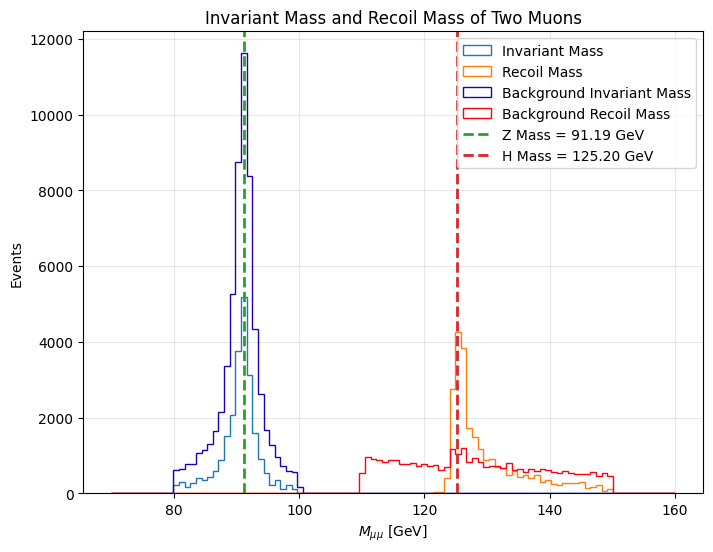

In [15]:
# Call the function
plot_muon_histograms(
    sig_filtered_invMass,
    sig_filtered_recoilMass,
    bg_filtered_invMass,
    bg_filtered_recoilMass,
    z_mass,
    h_mass,
    save_path="muon_histogram.png",   # writes the PNG file
    show=True                         # also pops up the window (optional)
)

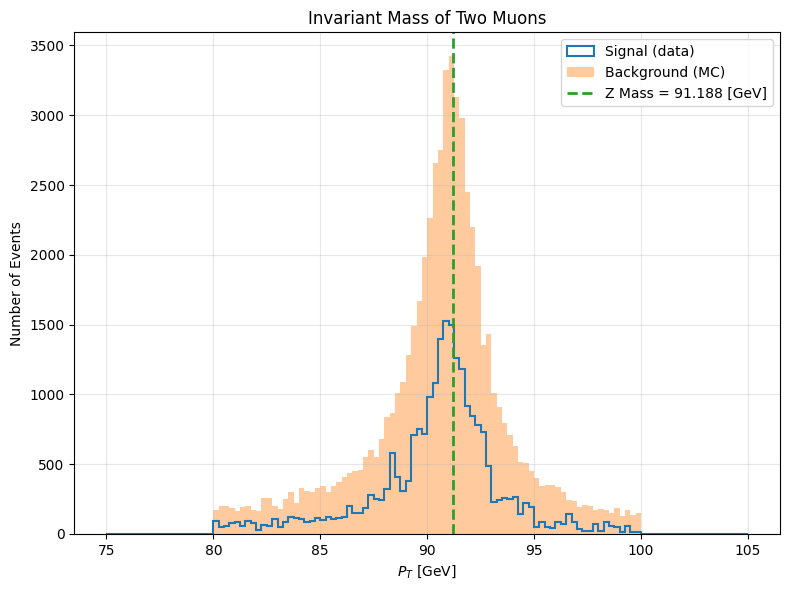

In [16]:
plot_histogram(
    signal_data=sig_filtered_invMass,
    background_data=bg_filtered_invMass,
    v_line=z_mass,
    bins=120,
    range_min=75,
    range_max=105,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Invariant Mass of Two Muons",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="invariant_mass.png",
    show_plot=True,
)

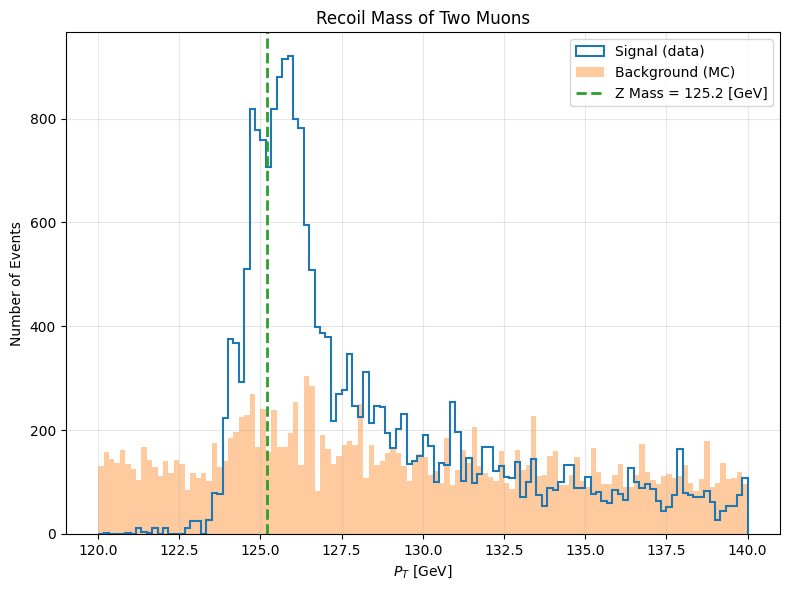

In [17]:
plot_histogram(
    signal_data=sig_filtered_recoilMass,
    background_data=bg_filtered_recoilMass,
    v_line=h_mass,
    bins=120,
    range_min=120,
    range_max=140,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Recoil Mass of Two Muons",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="recoil_mass.png",
    show_plot=True,
)

In [18]:
sig_px = nsig_df["px"]
sig_py = nsig_df["py"]
sig_pz = nsig_df["pz"]

bg_px = nbg_df["px"]
bg_py = nbg_df["py"]
bg_pz = nbg_df["pz"]

In [19]:
def plot_3d_scatter(
    signal_px,
    signal_py,
    signal_pz,
    background_px=None,
    background_py=None,
    background_pz=None,
    *,
    title="Muons 3‑D Momentum Scatter",
    figsize=(8, 6),
    cmap='viridis',
    point_size=30,
    alpha=0.7,
    bg_alpha=0.3,
    save_path="muon_3d_momentum.png",
    show_plot=True,
):
    """
    Create a 3‑D scatter plot of particle momenta.

    Parameters
    ----------
    signal_px, signal_py, signal_pz : array‑like
        Components of the *signal* momentum vectors (e.g. muons).
    background_px, background_py, background_pz : array‑like, optional
        Components of a secondary/background dataset that will be plotted
        with a lighter style.  If any of these are ``None`` the background
        series is omitted.
    figsize : tuple, default (8, 6)
        Size of the Matplotlib figure.
    cmap : str, default 'viridis'
        Colormap used to colour the signal points by their magnitude.
    point_size : float, default 30
        Marker size for the signal points.
    alpha : float, default 0.7
        Opacity for the signal markers.
    bg_alpha : float, default 0.3
        Opacity for the background markers.
    save_path : str, default "muon_3d_momentum.png"
        Where to write the PNG image.
    show_plot : bool, default True
        If ``True`` the figure is displayed via ``plt.show()``.
    """

    # ------------------------------------------------------------------
    # Assemble the signal magnitude for colour mapping
    # ------------------------------------------------------------------
    signal_momenta = np.column_stack((signal_px, signal_py, signal_pz))
    signal_mag = np.linalg.norm(signal_momenta, axis=1)

    # ------------------------------------------------------------------
    # Figure / 3‑D axis setup
    # ------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')

    # ------------------------------------------------------------------
    # Plot the main (signal) data
    # ------------------------------------------------------------------
    sc_signal = ax.scatter(
        signal_px,
        signal_py,
        signal_pz,
        c=signal_mag,
        cmap=cmap,
        s=point_size,
        alpha=alpha,
        label='Signal',
    )

    # ------------------------------------------------------------------
    # Optional background scatter
    # ------------------------------------------------------------------
    if (
        background_px is not None
        and background_py is not None
        and background_pz is not None
    ):
        ax.scatter(
            background_px,
            background_py,
            background_pz,
            c='red',
            s=point_size,
            alpha=bg_alpha,
            label='Background',
        )

    # ------------------------------------------------------------------
    # Axis labels, title, colour bar
    # ------------------------------------------------------------------
    ax.set_xlabel(r'$p_x$')
    ax.set_ylabel(r'$p_y$')
    ax.set_zlabel(r'$p_z$')
    ax.set_title(title)
    ax.legend()
    cbar = fig.colorbar(sc_signal, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label(r'$|\vec{p}|$ (magnitude)')

    # ------------------------------------------------------------------
    # Layout, save, optionally show
    # ------------------------------------------------------------------
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)   # free memory when called repeatedly

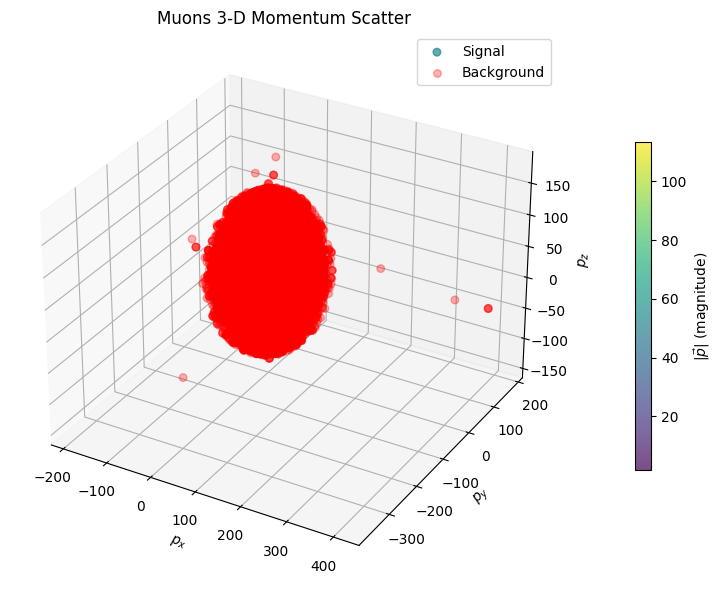

In [20]:
# Call the plotting routine
plot_3d_scatter(
    sig_px,
    sig_py,
    sig_pz,
    background_px=bg_px,
    background_py=bg_py,
    background_pz=bg_pz,
    title="Muons 3‑D Momentum Scatter",
    save_path="my_muon_scatter.png",
    show_plot=True,
)

## Muon Pair Energy Distribution Histogram

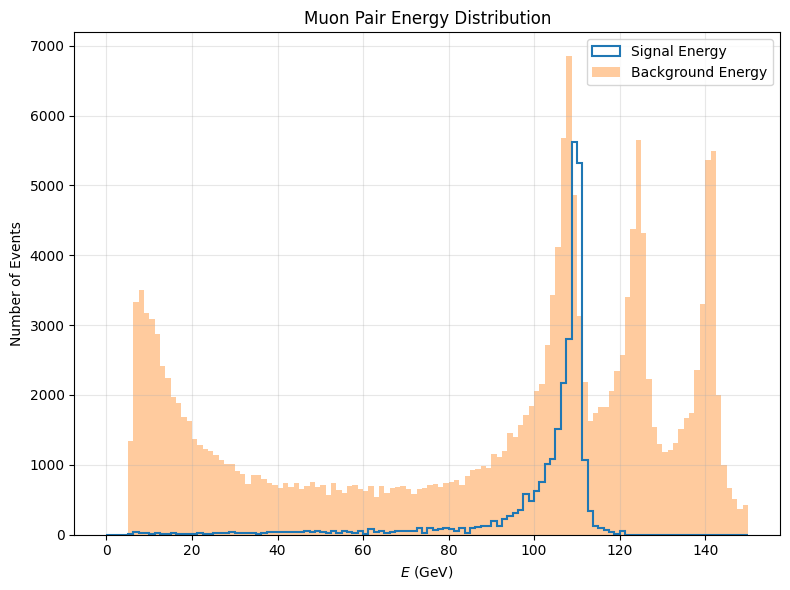

In [21]:
sig_energy = nsig_df["totalEnergy"]
bg_energy = nbg_df["totalEnergy"]

# --------------------------------------------------------------
# Produce the plot
# --------------------------------------------------------------
plot_histogram(
    signal_data=sig_energy,
    background_data=bg_energy,
    bins=120,
    range_min=0,
    range_max=150,
    signal_label="Signal Energy",
    background_label="Background Energy",
    title="Muon Pair Energy Distribution",
    xlabel=r"$E$ (GeV)",
    ylabel="Number of Events",
    save_path="muon_energy_comparison.png",
    show_plot=True,
)

## Transverse Energy of Two Muons Histogram

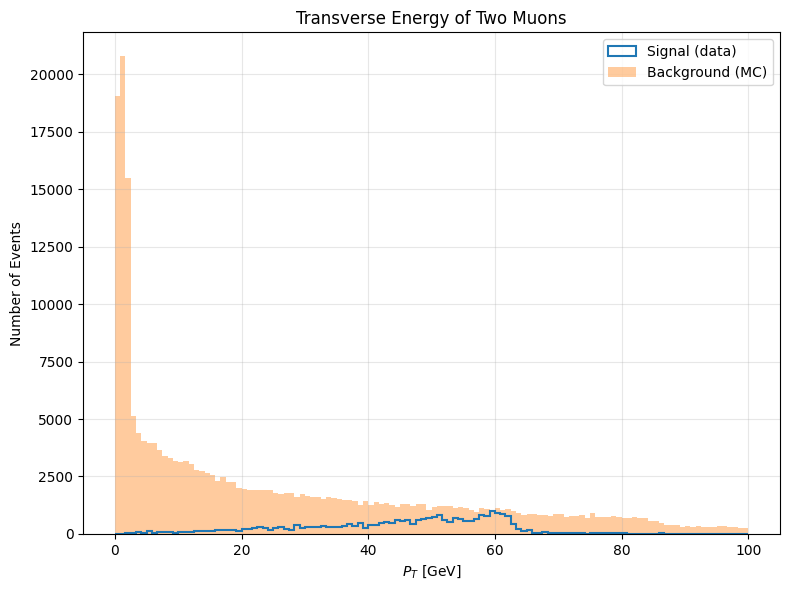

In [22]:
sig_met = nsig_df["met"]
bg_met = nbg_df["met"]

# --------------------------------------------------------------
# Produce the plot
# --------------------------------------------------------------
plot_histogram(
    signal_data=sig_met,
    background_data=bg_met,
    bins=120,
    range_min=0,
    range_max=100,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Transverse Energy of Two Muons",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="muon_energy_comparison.png",
    show_plot=True,
)

### Highest and Lowest Transverse energy muons

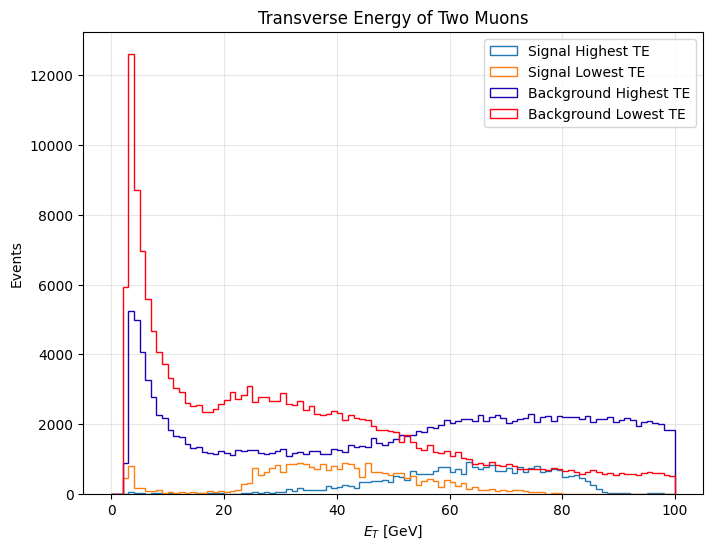

In [23]:
sig_muonEnergy_high = nsig_df["muonEnergy_high"]
sig_muonEnergy_low = nsig_df["muonEnergy_low"]

bg_muonEnergy_high = nbg_df["muonEnergy_high"]
bg_muonEnergy_low = nbg_df["muonEnergy_low"]

# Plot
plt.figure(figsize=(8,6))

# Invariant mass
# Signal
plt.hist(sig_muonEnergy_high, bins=100, range=(0,100), histtype="step", color="#1f77b4", label="Signal Highest TE")
plt.hist(sig_muonEnergy_low, bins=100, range=(0,100), histtype="step", color="#ff7f0e", label="Signal Lowest TE")

# Background
plt.hist(bg_muonEnergy_high, bins=100, range=(0,100), histtype="step", color="#1f00b4", label="Background Highest TE")
plt.hist(bg_muonEnergy_low, bins=100, range=(0,100), histtype="step", color="#ff000e", label="Background Lowest TE")


plt.xlabel(r"$E_{T}$ [GeV]")
plt.ylabel("Events")
plt.title("Transverse Energy of Two Muons")
plt.grid(alpha=0.3)

plt.legend()
plt.plot()
plt.savefig("muon_transverse_energy.png")

### Missing Energy Histogram

In [24]:
sig_missingEnergy= nsig_df["missingEnergy"]
bg_missingEnergy= nbg_df["missingEnergy"]

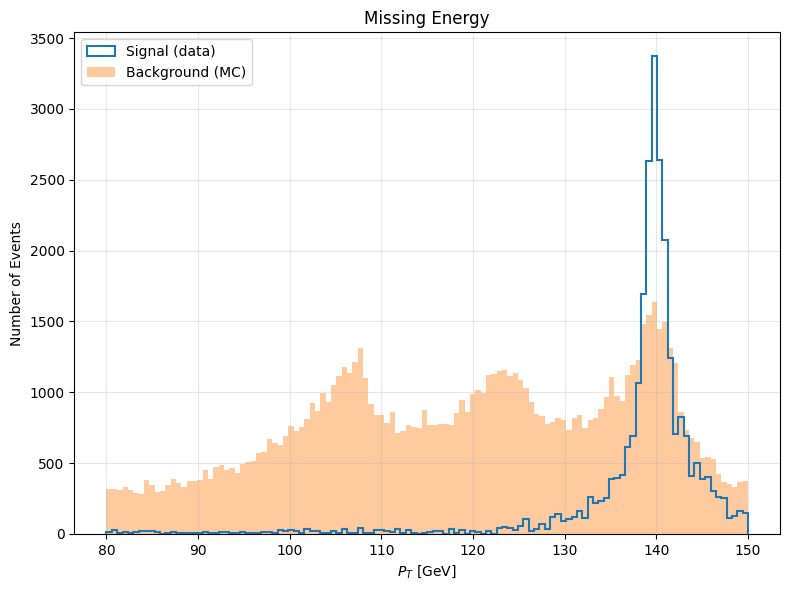

In [25]:
plot_histogram(
    signal_data=sig_missingEnergy,
    background_data=bg_missingEnergy,
    bins=120,
    range_min=80,
    range_max=150,
    signal_label="Signal (data)",
    background_label="Background (MC)",
    title="Missing Energy",
    xlabel=r"$P_{T}$ [GeV]",
    ylabel="Number of Events",
    save_path="missing_energy.png",
    show_plot=True,
)

### Muons 3‑D Missing Momentum Scatter

In [26]:
sig_missingPx = nsig_df["missingPx"]
sig_missingPy = nsig_df["missingPy"]
sig_missingPz = nsig_df["missingPz"]

bg_missingPx = nbg_df["missingPx"]
bg_missingPy = nbg_df["missingPy"]
bg_missingPz = nbg_df["missingPz"]

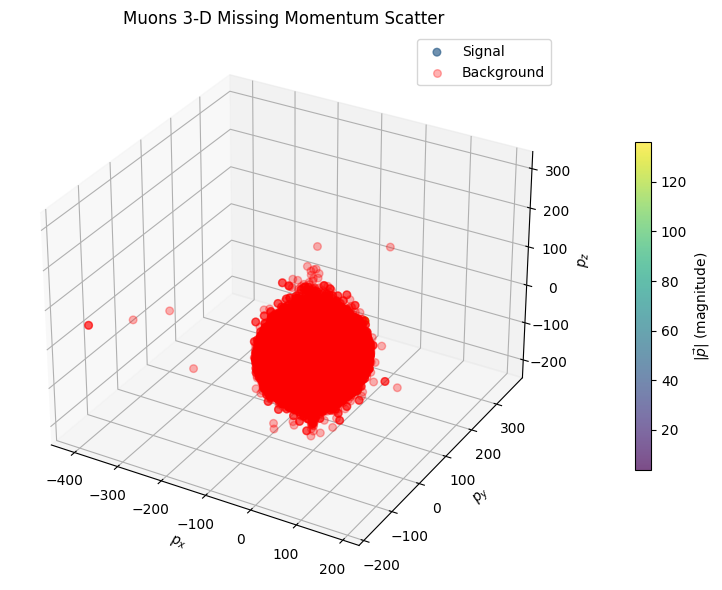

In [27]:
# Call the plotting routine
plot_3d_scatter(
    sig_missingPx,
    sig_missingPy,
    sig_missingPz,
    background_px=bg_missingPx,
    background_py=bg_missingPy,
    background_pz=bg_missingPz,
    title='Muons 3‑D Missing Momentum Scatter',
    save_path="muon_miss_3d_momentum.png",
    show_plot=True,
)

In [28]:
test_path = "/home/mazeeqe/Documents/mestrado/code/tomaz-example/build/hist.root"
test_file = uproot.open(test_path)

# Check Available Keys
print(test_file.keys())

# Import Events
test_tree = test_file["events"]

['events;1', 'NumEventsGenerated;1', 'CrossSection_pb;1', 'TargetLuminosity_fb;1']


In [29]:
test_df = load_histograms(test_path)
print(len(test_df))
test_df.head()

22


,invMass,recoilMass,totalEnergy,muonEnergy_high,muonEnergy_low,px,py,pz,met,missingEnergy,missingPx,missingPy,missingPz,weight
0,39.233585,158.298645,77.961624,57.385120,20.576504,54.928570,37.459465,-10.880306,66.485786,161.886475,-55.037842,-37.021957,17.302080,0.1
1,42.014553,93.244987,111.141190,102.940880,8.200310,55.897202,-54.652466,-66.901062,78.175377,138.174652,-55.795456,54.614826,67.007019,0.1
2,88.838806,145.068207,98.695099,58.931133,39.763966,12.595176,-39.475651,11.463991,41.436283,112.236221,-27.101200,25.675945,-42.312416,0.1
3,39.922070,118.538643,100.084724,93.958427,6.126295,46.761528,-78.907585,-3.183222,91.722672,142.583710,-47.594711,78.743332,3.436535,0.1
4,30.535297,192.090729,53.067112,41.889317,11.177795,16.179272,24.796883,31.734203,29.608347,192.358200,-16.242046,-24.820774,-28.453960,0.1


In [30]:
dup_mask = test_df.duplicated()
print(dup_mask)
num_dups = dup_mask.sum()
print(f"Number of duplicate rows: {num_dups}")

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
dtype: bool
Number of duplicate rows: 0


In [31]:
test_invMass = test_df["invMass"]
test_recoilMass = test_df["recoilMass"]



test_filtered_invMass = filter_between(test_invMass, 80, 100)
test_filtered_recoilMass = filter_between(test_recoilMass, 110, 150)

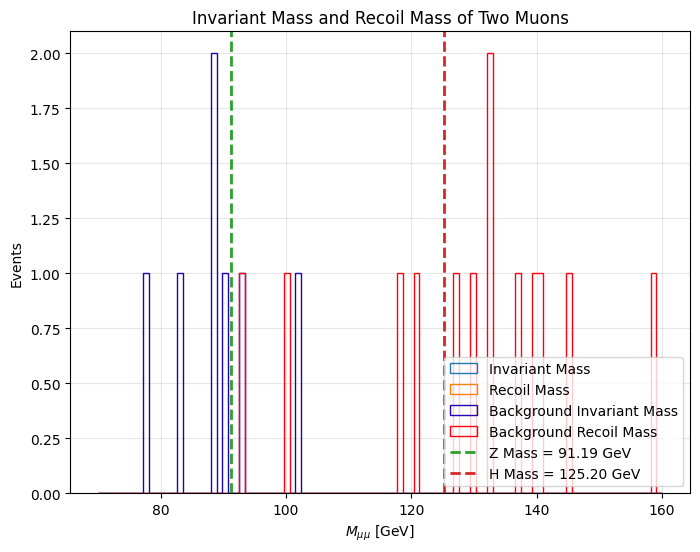

In [32]:
# Call the function
plot_muon_histograms(
    [0],
    [0],
    test_invMass,
    test_recoilMass,
    z_mass,
    h_mass,
    save_path="test.png",   # writes the PNG file
    show=True                         # also pops up the window (optional)
)